# Natural Language Processing  - Jupyter Notebook
### Cecilia, Conor, Francesco 
december 2019


# Intallation of differents packages

In [1]:
# pip install nltk 
# from the pop up window install: punkt, Averaged perceptron Tagger
# nltk.download()

In [2]:
#pip install spacy

In [ ]:
#pip install textacy

# Importation of packages

In [1]:
import copy
import json
import nltk
from nltk.tag import StanfordNERTagger
import os
import spacy
import textacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import word2vec
from sklearn.cluster import KMeans
from sklearn import cluster, metrics
from sklearn import neighbors, datasets
import snowballstemmer
from nltk.corpus import stopwords
import itertools
from string import ascii_lowercase
import seaborn as sns

# Importing and Cleaning the data

In [2]:
stemmer = snowballstemmer.EnglishStemmer()
stop = stopwords.words('english')
stoplist = stemmer.stemWords(stop)
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist)))

In [3]:
#File with ticker names associated with the company name
tickers= pd.read_json('data/word_vectors/SP500_Tickers.json', typ='series')
tickers

AGILENT TECHNOLOGIES          A
AMERICAN AIRLINES           AAL
ADVANCE AUTO PARTS          AAP
APPLE                      AAPL
ABBVIE                     ABBV
                           ... 
XYLEM                       XYL
YUM! BRANDS                 YUM
ZIMMER BIOMET HOLDINGS      ZBH
ZIONS BANCORPORATION NA    ZION
ZOETIS                      ZTS
Length: 500, dtype: object

In [4]:
################################################################################################################
#Do we still need this ? 
url2='data/word_vectors/article_headers_with_dates.txt'
url3 = 'parsed_scrapes/main.csv'
# url4 = '/Users/macbookpro/Downloads/parsed_main.csv'
################################################################################################################

#File with all the headlines
full_headers_path = 'headline_scraping/full_headlines.csv'
header = pd.read_csv(full_headers_path, sep = ",")
del header['Unnamed: 0']
header = header.drop_duplicates()
header

Headline      Date  \
0      ​ UDAY states see Rs 11,989-crore drop in inte...  20/03/17   
1      Income Tax India: 1 taxpayer owes 11% of India...  24/01/17   
2      $10 billion unhedged gap in foreign exchange d...  17/10/16   
3      10% cost reduction can add $5.5 billion to Ind...  19/01/17   
5      ​10% ethanol blending can save $1.7 billion in...  11/08/15   
...                                                  ...       ...   
65587  Sir Sandy Crombie to join RBS board | The Inde...  23/05/09   
65588  'We had a lot of fun': Sir Stephen Nickell ref...  25/01/17   
65589  Sir Tom calls time on Dobbies interest | The I...  21/05/08   
65590  Sir Victor Blank joins list for M&amp;S chairm...  16/05/10   
65591  Sirius Minerals: Future of Yorkshire employer ...  17/09/19   

                   Provider  
0      Economic Times India  
1      Economic Times India  
2      Economic Times India  
3      Economic Times India  
5      Economic Times India  
...                     ...  
65587       The Independent  
65588       The Independent  
65589       The Independent  
65590       The Independent  
65591       The Independent  

[64012 rows x 3 columns]

In [5]:
# remove characters and stoplist words, then generate dictionary of unique words
header['Original_Headline'] = header['Headline']

header['Headline'].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\$&]','',inplace=True,regex=True)

extensions_list = ['reuters','Reuters','bloomberg', 'may','also','could','would', 'na','&amp','gets', 'getting', 'get','must','might','may','across','among','beside','however','yet','within']+list(ascii_lowercase)

stop = stop.union(set(extensions_list))

wordlist = filter(None, " ".join(list(set(list(itertools.chain(*header['Headline'].str.split(' ')))))).split(" "))

header['Headline'] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in header['Headline'].str.lower().str.split(' ')]

header

Headline      Date  \
0      ​ uday states see rs crore drop interest cost ...  20/03/17   
1      income tax india taxpayer owes indias individu...  24/01/17   
2      billion unhedged gap foreign exchange deposit ...  17/10/16   
3      cost reduction add billion indias trade revenu...  19/01/17   
5      ​ ethanol blending save billion forex india re...  11/08/15   
...                                                  ...       ...   
65587       sir sandy crombie join rbs board independent  23/05/09   
65588  lot fun sir stephen nickell reflects austerity...  25/01/17   
65589    sir tom calls time dobbies interest independent  21/05/08   
65590  sir victor blank joins list mamps chairman ind...  16/05/10   
65591  sirius minerals future yorkshire employer ques...  17/09/19   

                   Provider                                  Original_Headline  
0      Economic Times India  ​ UDAY states see Rs 11,989-crore drop in inte...  
1      Economic Times India  Income Tax India: 1 taxpayer owes 11% of India...  
2      Economic Times India  $10 billion unhedged gap in foreign exchange d...  
3      Economic Times India  10% cost reduction can add $5.5 billion to Ind...  
5      Economic Times India  ​10% ethanol blending can save $1.7 billion in...  
...                     ...                                                ...  
65587       The Independent  Sir Sandy Crombie to join RBS board | The Inde...  
65588       The Independent  'We had a lot of fun': Sir Stephen Nickell ref...  
65589       The Independent  Sir Tom calls time on Dobbies interest | The I...  
65590       The Independent  Sir Victor Blank joins list for M&amp;S chairm...  
65591       The Independent  Sirius Minerals: Future of Yorkshire employer ...  

[64012 rows x 4 columns]

In [6]:
#Get the ticker into formatted dataframe
ticker = tickers.to_frame('Ticker').reset_index()
ticker.columns=['Name','Ticker']
ticker

Name Ticker
0       AGILENT TECHNOLOGIES      A
1          AMERICAN AIRLINES    AAL
2         ADVANCE AUTO PARTS    AAP
3                      APPLE   AAPL
4                     ABBVIE   ABBV
..                       ...    ...
495                    XYLEM    XYL
496              YUM! BRANDS    YUM
497   ZIMMER BIOMET HOLDINGS    ZBH
498  ZIONS BANCORPORATION NA   ZION
499                   ZOETIS    ZTS

[500 rows x 2 columns]

In [7]:
# Create a list of all the words/tickers of the company's names in the S&P500 
#In order to select only the headlines that concern the S&P500 companies. 

list_ticker = ticker['Name'].to_list()
list_tick = ticker['Ticker'].to_list()
str3 = '|'.join(list_tick)
str1 = '|'.join(list_ticker)
str1 = str1 + str3
str1 = str1.lower()
str1

"agilent technologies|american airlines|advance auto parts|apple|abbvie|amerisourcebergen|abiomed|abbott laboratories|accenture|adobe|analog devices|archer-daniels-midland|automatic data processing|alliance data systems|autodesk|ameren|american electric power|aes|aflac|allergan|american international|apartment investment & management|assurant|arthur j gallagher &|akamai technologies|albemarle|align technology|alaska air|allstate|allegion|alexion pharmaceuticals|applied materials|amcor|advanced micro devices|ametek|affiliated managers|amgen|ameriprise financial|american tower|amazoncom|arista networks|ansys|anthem|aon|a o smith|apache|air products & chemicals|amphenol|aptiv|alexandria real estate equities|arconic|atmos energy|activision blizzard|avalonbay communities|broadcom|avery dennison|american water works|american express|autozone|boeing|bank of america|baxter international|bb&t|best buy|becton dickinson &|franklin resources|brown-forman|baker hughes a ge|biogen|bank of new york m

In [8]:
#Selection among the headlines
isin = pd.DataFrame(header['Headline'].str.contains(str1, regex=True))
index = isin[isin['Headline']==True].reset_index()['index']
header = header.loc[index,:].reset_index()#[
header

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


index                                           Headline      Date  \
0          0  ​ uday states see rs crore drop interest cost ...  20/03/17   
1          1  income tax india taxpayer owes indias individu...  24/01/17   
2          2  billion unhedged gap foreign exchange deposit ...  17/10/16   
3          3  cost reduction add billion indias trade revenu...  19/01/17   
4          5  ​ ethanol blending save billion forex india re...  11/08/15   
...      ...                                                ...       ...   
64003  65587       sir sandy crombie join rbs board independent  23/05/09   
64004  65588  lot fun sir stephen nickell reflects austerity...  25/01/17   
64005  65589    sir tom calls time dobbies interest independent  21/05/08   
64006  65590  sir victor blank joins list mamps chairman ind...  16/05/10   
64007  65591  sirius minerals future yorkshire employer ques...  17/09/19   

                   Provider                                  Original_Headline  
0      Economic Times India  ​ UDAY states see Rs 11,989-crore drop in inte...  
1      Economic Times India  Income Tax India: 1 taxpayer owes 11% of India...  
2      Economic Times India  $10 billion unhedged gap in foreign exchange d...  
3      Economic Times India  10% cost reduction can add $5.5 billion to Ind...  
4      Economic Times India  ​10% ethanol blending can save $1.7 billion in...  
...                     ...                                                ...  
64003       The Independent  Sir Sandy Crombie to join RBS board | The Inde...  
64004       The Independent  'We had a lot of fun': Sir Stephen Nickell ref...  
64005       The Independent  Sir Tom calls time on Dobbies interest | The I...  
64006       The Independent  Sir Victor Blank joins list for M&amp;S chairm...  
64007       The Independent  Sirius Minerals: Future of Yorkshire employer ...  

[64008 rows x 5 columns]

# SVO and Name Entity Recognition

In [9]:
#####################################################################################################################
#Do we need it ? if so, put it at the beginning of the notebook....
#extraction = list(textacy.extract.subject_verb_object_triples(example))
#####################################################################################################################

nlp = spacy.load('en_core_web_sm')


#######################################################################################################################
#######################################################################################################################




def get_ticker1(name, tickers):
    '''
    Return a ticker of the company if the name is in the S&P500 companies
    '''
    for key, val in tickers.items():
        # Check if this is a ticker
        if val.upper() == name.upper():
            return f'__{val}'
        
        # Check that this is 
        if name.upper() in key.upper():
            return f'__{val}'
    return None

# def parse_header(header, max_company_name_length = max((len(x) for x in tickers))):
def parse_header1(header,tickers,orig):
    '''Attempt to replace all organisations in a header with their ticker
       Return a list with the SVO decomposition of the headline, the original headline and the cleaned headline 
    '''
    header = header.lower()
    
    #SVO tranformation
    nlp_header = nlp(header)
    tokens = list(textacy.extract.subject_verb_object_triples(nlp_header))  
    
    parsed_words = []
    #Replace the Object or the Suject of the SVO vector by a ticker if it matches with a S&P500 company
    for i in range(len(tokens)):
        ticker_0 = get_ticker1(str(tokens[i][0]), tickers)
        ticker_2 = get_ticker1(str(tokens[i][2]), tickers)  
        sub = str(tokens[i][0])
        obj = str(tokens[i][2])
        tick_sub = ''
        tick_obj = ''
        if ticker_0 is not None:
            sub = ticker_0
            tick_sub = 'sub'
        if ticker_2 is not None:
            obj = ticker_2
            tick_obj = 'obj'
        verb = str(tokens[i][1])
        tick = tick_sub + tick_obj
        
        if (ticker_0 != None) | (ticker_2 != None):
            parsed_words.append([sub, verb, obj, tick, header,orig])
        
    return parsed_words

In [10]:
print(len(header['Headline']))

svo_df = pd.DataFrame(columns = ['Date', 'Sub', 'Verb', 'Obj', 'Tick_Type', 'Headlines', 'Original Headline'])

for i in range (len(header['Headline'])):
    #print(i)
    headline = header.loc[i,'Headline']
    orig_head = header.loc[i,'Original_Headline'] 
    date = header.loc[i,'Date']
    svo_headlines = parse_header1(headline,tickers,orig_head)
    
    for ls in svo_headlines:
        svo_df.loc[len(svo_df)] =  [date] + ls

    
svo_df

64008


Date                             Sub     Verb                Obj  \
0     10/08/16                            __EL  default        pf payments   
1     22/08/17                           __AMG    crore  revenue loss year   
2     25/02/15                 recommendations    gives              __PKI   
3     25/02/15                 recommendations    gives             __MKTX   
4     29/07/16                   years reforms     meet               __DG   
...        ...                             ...      ...                ...   
7761  20/01/16                    sandberg men      run             __CHRW   
7762  29/12/10            shoppers flock sales     beat              __AMP   
7763   4/08/13                      founder uk     left             __ALXN   
7764  12/07/16                 joe kaeser vows   invest              __DRE   
7765   1/02/17  founder morrisons supermarkets     died              __AIV   

     Tick_Type                                          Headlines  \
0          sub  companies default pf payments epfo economic times   
1          sub      gst states see rs crore revenue loss year gst   
2          obj  th finance commission government accepts recom...   
3          obj  th finance commission government accepts recom...   
4          obj  years reforms meet entrepreneurs open era econ...   
...        ...                                                ...   
7761       obj  sheryl sandberg men still run world – im sure ...   
7762       obj     shoppers flock sales beat vat rise independent   
7763       obj  shore capital founder uk better left eu indepe...   
7764       obj  siemens boss joe kaeser vows invest uk brexit ...   
7765       obj  sir ken morrison dead founder morrisons superm...   

                                      Original Headline  
0     10,932 companies default on PF payments to EPF...  
1     GST: 11 states may see Rs 9,500 crore revenue ...  
2     14th Finance Commission: Government accepts re...  
3     14th Finance Commission: Government accepts re...  
4     25 years of reforms: Meet entrepreneurs of the...  
...                                                 ...  
7761  Sheryl Sandberg: ‘Men still run the world – an...  
7762  Shoppers flock to sales to beat VAT rise in 20...  
7763  Shore Capital founder: 'UK would be better off...  
7764  Siemens boss Joe Kaeser vows to invest in UK i...  
7765  Sir Ken Morrison dead: Founder of Morrisons su...  

[7766 rows x 7 columns]

# Training data & Tested data

In [11]:
#Order the dataframe by dates
svo_df['Date'] = pd.to_datetime(svo_df['Date'])
svo_df = svo_df.sort_values(by='Date')

# Separation training & tested data ( we chose 80%/20% but it is possible to change)
percentage_training = 80
length_training = int(np.floor(len(svo_df)*percentage_training/100))
date = svo_df['Date'].values
#Get the date at the limit between training and tested data
critical_date = date[length_training]
print(critical_date)

# Create the DataFrames for the training data and the tested data
training = svo_df[svo_df['Date']<=critical_date]
test_data = svo_df[svo_df['Date']>critical_date]
training

2018-11-21T00:00:00.000000000


Date        Sub      Verb          Obj Tick_Type  \
3810 1970-01-01      __ACN     works    thailands       sub   
3816 1970-01-01  venezuela      came       __CBOE       obj   
4477 1970-01-01        __A   cracked         fool       sub   
6573 1992-09-27      __AZO      fall      whizkid       sub   
6549 1993-01-04      __AAL      quit     stansted       sub   
...         ...        ...       ...          ...       ...   
6696 2018-11-21     __COST  s paying  independent       sub   
6695 2018-11-21     __COST  s paying       sticks       sub   
751  2018-11-21     __HBAN      snap       losing       sub   
883  2018-11-21     growth    passed        __HCP       obj   
3214 2018-11-21      __LMT    begins  manufacture       sub   

                                              Headlines  \
3810  accenture works thailands oldest bank release ...   
3816  venezuela came one biggest markets crypto worl...   
4477  fundsmiths terry smith good hes cracked motley...   
6573  emperor new clothes glory days amber day boss ...   
6549  american airlines quit stansted long haul carr...   
...                                                 ...   
6696  daniel hannans initiative free trade bangs bre...   
6695  daniel hannans initiative free trade bangs bre...   
751   european shares snap day losing streak tech it...   
883        global economic growth passed peak says oecd   
3214  lockheed martin begins manufacture skunk works...   

                                      Original Headline  
3810  Accenture Works With Thailand’s Oldest Bank to...  
3816  How Venezuela Came to Be One of the Biggest Ma...  
4477  Is Fundsmith’s Terry Smith as good as he’s cra...  
6573  Emperor in New Clothes: In the glory days Ambe...  
6549  American Airlines to quit Stansted: Long haul ...  
...                                                 ...  
6696  Daniel Hannan's Initiative for Free Trade bang...  
6695  Daniel Hannan's Initiative for Free Trade bang...  
751   European shares snap 5-day losing streak as te...  
883   Global economic growth has passed its peak, sa...  
3214  Lockheed Martin begins manufacture of Skunk Wo...  

[6216 rows x 7 columns]

# Word2Vec

In [62]:
##################################################################################################################""
# How to change the path of it ?? 
##################################################################################################################


#Import the model
model=word2vec.Word2Vec.load('/Users/macbookpro/Documents/GitHub/nlp/word_vectors/models/model_1')
X = model[model.wv.vocab]

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [63]:
##################################################################################################################
# Do we still need this ? what happen if we dont run it ? 
###################################################################################################################

num_clusters = 100
kmeans = cluster.KMeans(n_clusters=num_clusters)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## Create phrases vectors
#### (Concatenating the vectors)

In [14]:
data = []

to_parse = {
    'obj': 'Sub',
    'sub': 'Obj',
    'subobj': 'Verb'
}

for i in training.index:
    entry = {}
    for key in ['Date', 'Sub', 'Verb','Obj', 'Tick_Type', 'Headlines', 'Original Headline']:
        entry[key] = training.loc[i, key]
        
#     print(entry['Verb'])
    
    try:
        verb_vector = model.wv[entry['Verb'].upper()]
    except:
        verb_vector = None
    key_to_parse = to_parse[entry['Tick_Type']]
    
    try:
        other_vector = model.wv[entry[key_to_parse].upper()]
    except:
        other_vector = None
        
    if verb_vector is not None and other_vector is not None:
        final_vector = np.concatenate((verb_vector, other_vector))
        entry['final_vector'] = final_vector
    else:
        entry['final_vector'] = None
    
    data.append(entry)
    


In [15]:
data

[{'Date': Timestamp('1970-01-01 00:00:00'),
  'Sub': '__ACN',
  'Verb': 'works',
  'Obj': 'thailands',
  'Tick_Type': 'sub',
  'Headlines': 'accenture works thailands oldest bank release blockchain supply chain tool cointelegraph',
  'Original Headline': 'Accenture Works With Thailand’s Oldest Bank to Release Blockchain Supply Chain Tool By Cointelegraph',
  'final_vector': array([ 1.55213356e-01, -1.44703388e+00,  2.27142662e-01, -1.52253911e-01,
         -6.82662845e-01, -6.36910975e-01, -8.14134300e-01, -4.75596905e-01,
          9.17704850e-02,  9.94647682e-01, -1.42802393e+00, -3.83197069e-01,
          2.18832359e-01,  4.46050942e-01,  1.44260263e+00, -1.60300642e-01,
         -5.19617558e-01,  4.34082776e-01, -4.36207443e-01, -9.43377316e-01,
         -6.70193493e-01,  4.32901502e-01,  4.15040791e-01, -1.53777912e-01,
         -1.26467538e+00, -6.20164335e-01,  8.78869772e-01, -3.95437568e-01,
         -4.23765630e-02, -2.00110495e-01,  2.24139071e+00,  6.78865314e-01,
         

# Determine which tickers are the most quoted by articles

{'tickers': ['__ACN', '__CBOE', '__A', '__PBCT', '__TSCO', '__COST', '__DRE', '__EL', '__CF', '__AAL', '__APD', '__BAC', '__NDAQ', '__BKNG', '__STI', '__ROST', '__AMG', '__MSI', '__CDNS', '__HBAN', '__ADM', '__GPN', '__DG', '__ALXN', '__BLK', '__C', '__MSFT', '__CRM', '__FB', '__EBAY', '__EW', '__AVB', '__COF', '__HCA', '__PNC', '__FRC', '__WCG', '__HPE', '__IBM', '__AIV', '__ORCL', '__AAP', '__ATO', '__CAG', '__JCI', '__CTL', '__SYK', '__KSU', '__CFG', '__AEP', '__AMZN', '__AAPL', '__ESS', '__ANET', '__AON', '__EXR', '__SHW', '__ICE', '__IP', '__WAB', '__ADP', '__INTC', '__BRK.B', '__GS', '__F', '__TRIP', '__FIS', '__WM', '__ADS', '__CAT', '__DFS', '__NFLX', '__BK', '__DRI', '__CHTR', '__MAR', '__FBHS', '__COO', '__TWTR', '__JEC', '__AMD', '__FMC', '__MPC', '__ARE', '__AZO', '__CHRW', '__DGX', '__NWSA', '__DISH', '__TXT', '__HRL', '__GIS', '__AFL', '__BR', '__ABBV', '__STT', '__PG', '__CL', '__EXPD', '__BDX', '__FLS', '__MMC', '__MKTX', '__AOS', '__COG', '__DOW', '__TROW', '__PEP', '_

tickers  counts
1   __CBOE     147
8     __CF     110
87  __NWSA     102
23  __ALXN      94
14   __STI      67

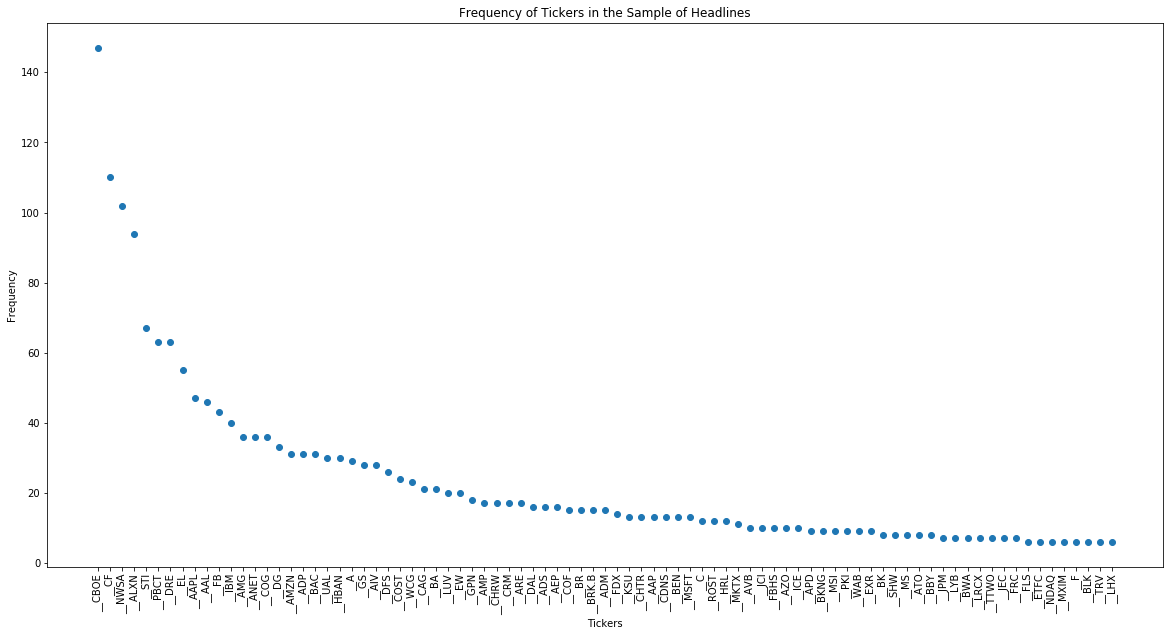

In [24]:
#Select the SVO vectors that present a ticker
tickers_list = []
for x in data:
    if (x['Tick_Type'] == 'sub')&(x['final_vector'] is not None):
        tickers_list.append(x['Sub'])
    elif (x['Tick_Type'] == 'obj')&(x['final_vector'] is not None):
        tickers_list.append(x['Obj'])

#Count the number of times that each ticker appears
from collections import Counter
counts = dict(Counter(tickers_list))

to_parse = {'tickers': [], 'counts': []}
for ticker, count in counts.items():
    to_parse['tickers'].append(ticker)
    to_parse['counts'].append(count)
print(to_parse)
    

#Get the count of the ticker in a DataFrame
ticker_counts = pd.DataFrame(to_parse)
ticker_counts = ticker_counts.sort_values(by = 'counts', ascending = False)

#Select the tickers that appears more than 5 times in the headlines, in order to plot a relevant graph 
ticker_counts1 = ticker_counts[ticker_counts['counts']>5]

#Plot
plt.figure(figsize = [20,10])
plt.scatter(ticker_counts1['tickers'], ticker_counts1['counts'])
plt.xticks(rotation = 'vertical')
plt.title('Frequency of Tickers in the Sample of Headlines')
plt.xlabel('Tickers')
plt.ylabel('Frequency')
plt.savefig('Tickers_Frequency', dpi = 1000)
ticker_counts.head()


# Clustering phrases vectors

In [75]:
#Select only the headlines that have a final vector
relevant_data = [x for x in data if x['final_vector'] is not None]

In [76]:
#Clustering
vocab = [x['final_vector'] for x in relevant_data]
num_clusters = 100
kmeans = cluster.KMeans(n_clusters = num_clusters)
kmeans.fit(vocab)
print(len(vocab))

2726


# Mapping

In [77]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(len(labels))
# print(centroids)

2726


In [28]:
for i in range(len(relevant_data)):
    relevant_data[i]['cluster_label'] = labels[i]

In [29]:
n_neighbors = 5
y = labels

h = .02  # step size in the mesh

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, algorithm = 'ball_tree')
    clf.fit(vocab, y)

In [30]:
print(clf.fit(vocab, y))

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')


In [169]:
# Create a Dataframe with the 100 clusters with 5 representatives for the verb 
# and 5 for the object of each

columns_verbs = ['Cluster No','Verb1','Verb2','Verb3','Verb4','Verb5','Obj1','Obj2','Obj3','Obj4','Obj5']

clusters_table = pd.DataFrame(columns = columns_verbs)

for i in range(len(centroids)):
    centroid_Verb_Obj = np.split(centroids[i],2) #each vector is just the concatenation of verb and obj vectors
    similar_centroid_Verb = model.wv.similar_by_vector(centroid_Verb_Obj[0],5)
    similar_centroid_Obj = model.wv.similar_by_vector(centroid_Verb_Obj[1],5)
    
    list_similar_verb = [i]
    list_similar_obj = []
    
    for j in range(5):
        list_similar_verb.append(similar_centroid_Verb[j][0])
        list_similar_obj.append(similar_centroid_Obj[j][0])
    list_cluster = list_similar_verb + list_similar_obj
    clusters_table.loc[len(clusters_table)] = list_cluster
print(clusters_table)
clusters_table.to_csv('Clusters_dictionary.csv')

Empty DataFrame
Columns: [Cluster No, Verb1, Verb2, Verb3, Verb4, Verb5, Obj1, Obj2, Obj3, Obj4, Obj5]
Index: []
   Cluster No       Verb1     Verb2    Verb3        Verb4        Verb5  \
0           0      PUSHES      HITS    DROVE        SENDS        LOSES   
1           1  STRENGTHEN   ENHANCE   EXPAND   ACCELERATE      IMPROVE   
2           2       GIVES    BRINGS     PUTS         SEES      CREATES   
3           3        DROP   DECLINE     RISE         FALL        SLUMP   
4           4    LAUNCHES   UNVEILS   LAUNCH     LAUNCHED    LAUNCHING   
..        ...         ...       ...      ...          ...          ...   
95         95        SAVE     SPEND   BORROW       DONATE        SAVED   
96         96       FIGHT  FIGHTING   BATTLE      PROTEST  CAMPAIGNING   
97         97      CHANGE   CHANGES    SHIFT  ADJUSTMENTS     CHANGING   
98         98       TELLS   REMINDS  TELLING         TELL    REMINDING   
99         99       WANTS     URGED   WANTED        FAILS      DECIDES   

# Returns study

In [32]:
##############################################################################################################
#Path ???
##############################################################################################################

#Open the returns as DataFrame
returnsdf = pd.read_csv('/Users/macbookpro/Documents/GitHub/nlp/data/returns/returnsSP500.csv')
returnsdf

Date         A       AAL       AAP      AAPL      ABBV       ABC  \
0     2000-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
1     2000-01-04 -0.076389       NaN       NaN -0.084310       NaN -0.068273   
2     2000-01-05 -0.062030       NaN       NaN  0.014634       NaN  0.077586   
3     2000-01-06 -0.038076       NaN       NaN -0.086538       NaN  0.076000   
4     2000-01-07  0.083333       NaN       NaN  0.047368       NaN  0.130112   
...          ...       ...       ...       ...       ...       ...       ...   
5008  2019-11-27  0.001606 -0.003442  0.010758  0.013432  0.006954  0.007513   
5009  2019-11-29 -0.003823 -0.007254 -0.010707 -0.002203 -0.006793 -0.006779   
5010  2019-12-02 -0.005200 -0.022965 -0.003374 -0.011562 -0.007979 -0.000910   
5011  2019-12-03 -0.003111 -0.028134 -0.025168 -0.017830 -0.012410 -0.004554   
5012  2019-12-04  0.007615  0.014291  0.000301  0.011440  0.014654  0.010751   

          ABMD       ABT       ACN  ...       XEL      XLNX       XOM  \
0          NaN       NaN       NaN  ...       NaN       NaN       NaN   
1    -0.023973 -0.028571       NaN  ...  0.023026 -0.022727 -0.019154   
2     0.010526 -0.001838       NaN  ...  0.038585 -0.021888  0.054516   
3     0.001736  0.034991       NaN  ... -0.009288 -0.086713  0.051698   
4    -0.005199  0.010676       NaN  ...  0.000000  0.113323 -0.002935   
...        ...       ...       ...  ...       ...       ...       ...   
5008  0.013024  0.000000  0.001642  ...  0.006211  0.023126 -0.000582   
5009 -0.003100  0.000351 -0.000447  ... -0.001137 -0.006106 -0.008297   
5010 -0.020186 -0.011001 -0.007805  ... -0.004716 -0.027053  0.004257   
5011 -0.005567 -0.001775 -0.004209  ...  0.004248 -0.017946 -0.007892   
5012  0.011143  0.006046  0.004428  ...  0.005125  0.013649  0.009944   

          XRAY       XRX       XYL       YUM       ZBH      ZION       ZTS  
0          NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1     0.000000 -0.046512       NaN -0.020100       NaN -0.048423       NaN  
2     0.017287  0.051490       NaN  0.005128       NaN -0.001183       NaN  
3     0.001307 -0.020619       NaN -0.008503       NaN  0.014218       NaN  
4    -0.002611  0.023684       NaN -0.022298       NaN  0.002336       NaN  
...        ...       ...       ...       ...       ...       ...       ...  
5008  0.001227  0.013055  0.005962  0.008922  0.011735  0.008256 -0.002133  
5009 -0.009981  0.003351 -0.001288  0.000298 -0.008734 -0.005792 -0.009126  
5010  0.002830 -0.011045 -0.012385 -0.001093 -0.005644 -0.005625 -0.005061  
5011  0.007584 -0.006494 -0.013194 -0.011038 -0.007338 -0.018788  0.005171  
5012  0.004726  0.009150  0.009134 -0.001207  0.030858  0.014000 -0.003982  

[5013 rows x 501 columns]

In [33]:
##############################################################################################################
#Path ???
##############################################################################################################


#Get the parameters (Beta and GICS classification) of each ticker of the S&P500
params = pd.read_csv('/Users/macbookpro/Documents/GitHub/nlp/data/SP500_parameters.csv')
#Since we use two forms for the tickers, we have two columns for them
params['Ticker_b']=params['Ticker']
params['Ticker']='__'+params['Ticker']
params

Ticker      Beta                      Name                    GICS  \
0       __A  1.165846  Agilent Technologies Inc             Health Care   
1     __AAL  1.570904   American Airlines Group             Industrials   
2     __AAP  0.680250        Advance Auto Parts  Consumer Discretionary   
3    __AAPL  1.488606                Apple Inc.  Information Technology   
4    __ABBV  0.889469               AbbVie Inc.             Health Care   
..      ...       ...                       ...                     ...   
496   __XYL  1.096964                Xylem Inc.             Industrials   
497   __YUM  0.484074           Yum! Brands Inc  Consumer Discretionary   
498   __ZBH  0.901953    Zimmer Biomet Holdings             Health Care   
499  __ZION  1.049443             Zions Bancorp              Financials   
500   __ZTS  0.950043                    Zoetis             Health Care   

    Ticker_b  
0          A  
1        AAL  
2        AAP  
3       AAPL  
4       ABBV  
..       ...  
496      XYL  
497      YUM  
498      ZBH  
499     ZION  
500      ZTS  

[501 rows x 5 columns]

## Which industries are the most tackled by headlines 
##### in order to have enough data to study

In [34]:
ticker_counts.columns=['Ticker','count']
ticker_counts = ticker_counts.merge(params[['Ticker','GICS']],on = 'Ticker')

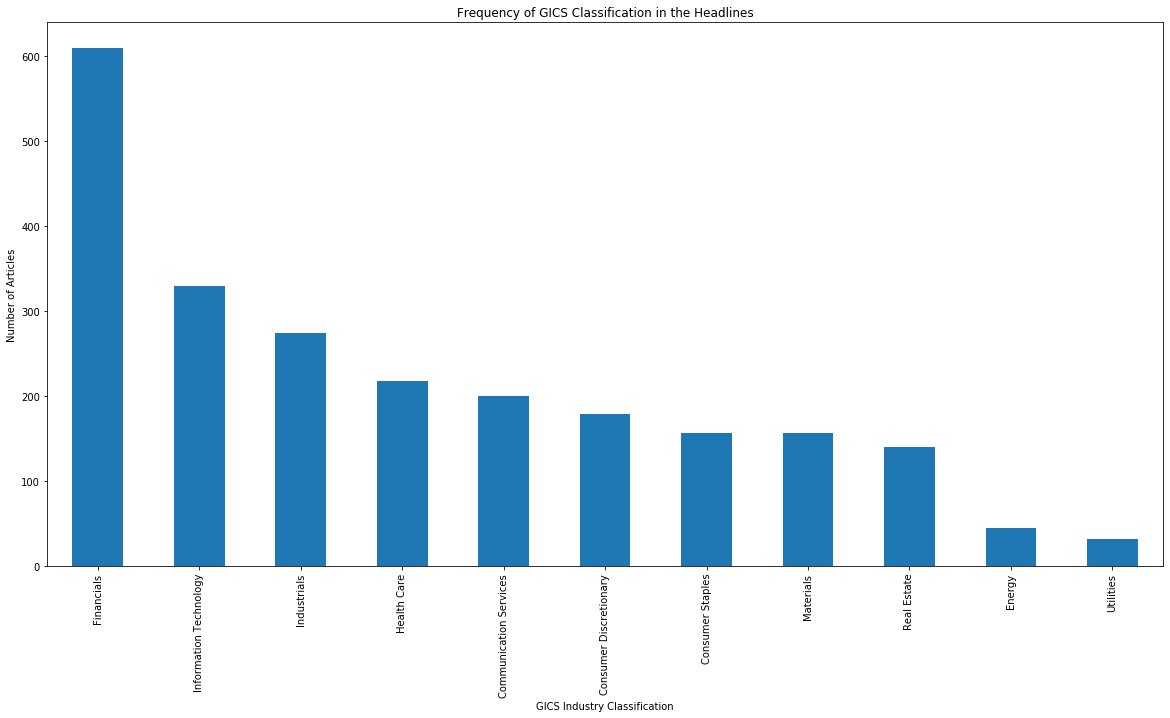

In [36]:
GICS_count = ticker_counts.groupby(['GICS']).agg(['sum'])
GICS_count =GICS_count.sort_values(by = ('count','sum'),ascending=False)


plt.figure(figsize = [20,10])
GICS_count[('count','sum')].plot(kind='bar')

plt.xlabel('GICS Industry Classification')
plt.ylabel('Number of Articles')
plt.title('Frequency of GICS Classification in the Headlines')
plt.savefig('GICS_Frequency', dpi = 1000)

# Create a DataFrame of returns for each type of Industry
It is useful in order to compute the expected returns of one industry, and then, to eliminate the industry performance from the company performance thanks to the CAPM

In [37]:
industries = set(params['GICS'].values)

#Each dataframe is stock into the following dictionary, which allows to associate the dataframe and its industry
dataframe_industry_dict = {}
for industry in industries:
    #get the tickers of one inductry
    industry_tickers = params.loc[params['GICS'] == industry, 'Ticker']
    industry_tickers = industry_tickers.str.replace('__','')
    industry_tickers = industry_tickers.str.replace('.','-')
    industry_tickers = list(set(industry_tickers) & set(returnsdf.columns))
    
    #Get the returns for those tickers
    df_industry = returnsdf[industry_tickers + ['Date']]
    df_industry['market_exp'] = df_industry[industry_tickers].mean(axis=1)
    df_industry = df_industry.iloc[1:,:]
    
    #reorder columns
    cols = df_industry.columns
    cols = cols[-2:].append(cols[:(len(cols)-2)])
    df_industry = df_industry[cols]
    
    #Add the dataframe to the dictionary
    dataframe_industry_dict[industry] = df_industry

#Example of the DataFrame for the Financial industry : 
dataframe_industry_dict['Financials']

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Date  market_exp       PRU      SIVB     BRK-B       PNC  \
1     2000-01-04   -0.035024       NaN -0.064858 -0.034561 -0.031111   
2     2000-01-05   -0.006698       NaN -0.032787  0.016432  0.004587   
3     2000-01-06    0.023833       NaN  0.024446  0.041571  0.047184   
4     2000-01-07    0.021625       NaN  0.006682  0.008869  0.001453   
5     2000-01-10   -0.013937       NaN  0.054362 -0.003846 -0.034833   
...          ...         ...       ...       ...       ...       ...   
5008  2019-11-27    0.004481  0.000959  0.008199  0.007309  0.002616   
5009  2019-11-29   -0.002879 -0.003194 -0.013369 -0.000907 -0.000522   
5010  2019-12-02   -0.008494 -0.007263 -0.008372  0.000136 -0.008028   
5011  2019-12-03   -0.014515 -0.027545 -0.019670 -0.010212 -0.014739   
5012  2019-12-04    0.011593  0.010168  0.028943  0.001172  0.010084   

           COF      SPGI       USB      CBOE  ...        RE      NTRS  \
1    -0.062246 -0.045989 -0.036474       NaN  ... -0.002857 -0.065015   
2    -0.023088 -0.013453 -0.022082       NaN  ...  0.065903  0.022517   
3     0.045790 -0.027273  0.077419       NaN  ...  0.045699  0.020725   
4     0.028249  0.009346  0.038922       NaN  ...  0.053985  0.012690   
5    -0.012363  0.069444 -0.005764       NaN  ... -0.004878 -0.025063   
...        ...       ...       ...       ...  ...       ...       ...   
5008  0.010381 -0.005245  0.004506 -0.009036  ...  0.001432  0.008900   
5009 -0.002394 -0.003202 -0.002658  0.003884  ... -0.005499 -0.004179   
5010 -0.007799 -0.009295 -0.004498  0.003196  ... -0.009032 -0.006714   
5011 -0.010682  0.006903 -0.013889  0.006623  ... -0.011123 -0.011359   
5012  0.011816  0.010814  0.009079  0.001582  ...  0.006696  0.012440   

           ICE       FRC       TRV        GL       CMA       PFG      PBCT  \
1          NaN       NaN -0.013258 -0.019868 -0.041667       NaN -0.002994   
2          NaN       NaN -0.007678  0.000000 -0.002899       NaN  0.006006   
3          NaN       NaN  0.019342 -0.002252  0.029070       NaN -0.008955   
4          NaN       NaN  0.039848  0.020316 -0.001412       NaN -0.006024   
5          NaN       NaN -0.018248 -0.013274 -0.032532       NaN -0.018182   
...        ...       ...       ...       ...       ...       ...       ...   
5008 -0.011009  0.013217  0.001171  0.007621  0.008960  0.010432  0.006109   
5009  0.007920 -0.004439 -0.000877 -0.003588 -0.007471 -0.001992  0.001822   
5010 -0.009239  0.001547 -0.010679 -0.003406 -0.004403 -0.022686 -0.011515   
5011  0.001608 -0.009085 -0.004732 -0.016405 -0.016405 -0.027855 -0.009810   
5012 -0.002515  0.013936  0.003491  0.009431  0.021784  0.013372  0.011455   

          ZION  
1    -0.048423  
2    -0.001183  
3     0.014218  
4     0.002336  
5    -0.018065  
...        ...  
5008  0.008256  
5009 -0.005792  
5010 -0.005625  
5011 -0.018788  
5012  0.014000  

[5012 rows x 69 columns]

# LIBOR 3M importation
We use the LIBOR 3M rate as the risk free rate for the CAPM model

In [38]:
##################################################################################################""
#Path
##################################################################################################

libor = pd.read_excel('/Users/macbookpro/Documents/GitHub/nlp/data/LIBOR_3M.xlsx')
libor['LIBOR 3M'] = libor['LIBOR 3M']/100
libor['Date'] = pd.to_datetime(libor['Date'])
libor

Date  LIBOR 3M
0    2010-01-01  0.002506
1    2010-01-04  0.002544
2    2010-01-05  0.002525
3    2010-01-06  0.002500
4    2010-01-07  0.002494
...         ...       ...
2481 2019-07-08  0.023377
2482 2019-07-09  0.023407
2483 2019-07-10  0.023395
2484 2019-07-11  0.023034
2485 2019-07-12  0.023223

[2486 rows x 2 columns]

In [39]:
#Insert the LIBOR 3M rate into the dataframe of returns for each industry by merging on the dates
for industry in industries:
    test = dataframe_industry_dict[industry]
    test['Date'] = pd.to_datetime(test['Date'])
    #merge
    test = test.merge(libor,on = 'Date')
    #reorder columns
    cols = test.columns
    cols = cols[-1:].append(cols[:(len(cols)-1)])
    test = test[cols]
    dataframe_industry_dict[industry] = test
    
#Example of the Financial industry
dataframe_industry_dict['Financials']

LIBOR 3M       Date  market_exp       PRU      SIVB     BRK-B       PNC  \
0     0.002544 2010-01-04    0.018151  0.040394  0.031685  0.007608  0.013639   
1     0.002525 2010-01-05    0.010028  0.019703 -0.009307  0.004832  0.010092   
2     0.002500 2010-01-06    0.003747  0.011745  0.008220 -0.005110  0.000000   
3     0.002494 2010-01-07    0.019587  0.016102  0.040997  0.003928  0.054209   
4     0.002512 2010-01-08    0.001277 -0.013083  0.064892 -0.000301  0.002633   
...        ...        ...         ...       ...       ...       ...       ...   
2392  0.023377 2019-07-08   -0.008997 -0.008468 -0.034679 -0.000557 -0.005863   
2393  0.023407 2019-07-09    0.004561 -0.002749  0.011944 -0.001766  0.000355   
2394  0.023395 2019-07-10   -0.005527 -0.008268 -0.023422 -0.003353 -0.005256   
2395  0.023034 2019-07-11    0.006526  0.003871  0.020833 -0.004018  0.010068   
2396  0.023223 2019-07-12    0.006617  0.013546  0.023863  0.004363  0.005160   

           COF      SPGI       USB  ...        RE      NTRS       ICE  \
0     0.018518  0.002984  0.016437  ... -0.002684  0.002481  0.005076   
1     0.039437  0.000893  0.025350  ... -0.014511 -0.001333 -0.037654   
2     0.005420 -0.008918  0.010656  ... -0.000356 -0.014487 -0.030841   
3     0.049498  0.022196  0.019401  ...  0.002019  0.009478  0.027263   
4    -0.008639 -0.003815  0.001655  ... -0.001778  0.004407  0.003144   
...        ...       ...       ...  ...       ...       ...       ...   
2392 -0.007997 -0.019451 -0.010805  ...  0.000000 -0.023957 -0.001229   
2393  0.005338 -0.003916  0.004520  ...  0.011316 -0.000873  0.002125   
2394 -0.023079  0.014170 -0.003000  ...  0.003419 -0.012774  0.007701   
2395  0.006100  0.015676  0.005453  ... -0.005382  0.010175  0.015949   
2396  0.003969  0.011827  0.002431  ...  0.003270  0.000000 -0.001962   

           FRC       TRV        GL       CMA       PFG      PBCT      ZION  
0          NaN -0.001003  0.018430  0.031451  0.039933  0.002994  0.038971  
1          NaN -0.023690  0.022788  0.003607  0.023600  0.005970  0.035259  
2          NaN -0.014189  0.007208  0.022215 -0.006643 -0.000593  0.086957  
3          NaN  0.014393 -0.000217  0.054330  0.008655  0.004751  0.112000  
4          NaN -0.001439 -0.000217 -0.012731  0.001170  0.004728 -0.016187  
...        ...       ...       ...       ...       ...       ...       ...  
2392 -0.005990 -0.001882 -0.009807 -0.015073 -0.009522 -0.010000 -0.019260  
2393  0.014464 -0.002276  0.007373  0.010712  0.003777 -0.001783  0.013460  
2394 -0.004950 -0.000782 -0.004588 -0.016105 -0.006670 -0.011309 -0.014152  
2395  0.006368 -0.005870  0.006146  0.014969  0.002410  0.007224  0.012368  
2396 -0.005043  0.006298  0.004036  0.003997  0.015459  0.007173  0.011780  

[2397 rows x 70 columns]

# Computation of abnormal returns

We compute the abnormal returns by taking the difference between the returns and the CAPM returns for every tickers in each industry

In [41]:
#Each DataFrame for one industry is stocked in the following dictionary and associated to its industry type.
abret_dict = {}

for industry in industries:
    df_returns = dataframe_industry_dict[industry]
    
    #CAPM components
    risk_free_rate = df_returns['LIBOR 3M']
    market_avg_returns = df_returns['market_exp']
    
    #Initialisation
    abret_dict[industry] = pd.DataFrame(df_returns['Date'])
    capm = pd.DataFrame(df_returns['Date'])
    
    for col in df_returns.columns[3:]:
        col = col.replace('-', '.')
        
        #CAPM components
        beta = params.loc[params['Ticker_b'] == col]['Beta'].values[0]
        stock_returns = returnsdf[col.replace('.', '-')]
        
        #CAPM computation
        capm[col] = risk_free_rate + beta*(market_avg_returns-risk_free_rate)
        
        #Abreturns computation
        abret_dict[industry][col] = stock_returns - capm[col]
        abret_dict[industry] = abret_dict[industry].where((pd.notnull(abret_dict[industry])), None)
        
#Example of the Financials industry
abret_dict['Financials']

Date         PRU        SIVB       BRK.B          PNC        COF  \
0    2010-01-04        None        None        None         None       None   
1    2010-01-05        None  -0.0792482  -0.0437838   -0.0407285  -0.074012   
2    2010-01-06        None   -0.037259   0.0128185  0.000908272  -0.027124   
3    2010-01-07        None -0.00507614   0.0238185    0.0285337  0.0222459   
4    2010-01-08        None  0.00612231  0.00745936  0.000108609  0.0272574   
...         ...         ...         ...         ...          ...        ...   
2392 2019-07-08     0.04822    0.051487 -0.00870857    0.0135503  0.0471191   
2393 2019-07-09  -0.0151202  -0.0366685  -0.0159667   -0.0285566 -0.0270841   
2394 2019-07-10    0.105522   0.0419214   0.0326594    0.0654984  0.0718456   
2395 2019-07-11  0.00615499  0.00184354  0.00655373   -0.0401132  0.0544784   
2396 2019-07-12   0.0542388   0.0496799   0.0159909     0.051874   0.115359   

            SPGI         USB  CBOE         MMC  ...          RE        NTRS  \
0           None        None  None        None  ...        None        None   
1     -0.0558786  -0.0454245  None  -0.0535551  ... -0.00879667  -0.0764217   
2      -0.017177    -0.02565  None  -0.0394978  ...    0.062835   0.0185403   
3     -0.0465426   0.0602884  None   0.0453787  ...   0.0354267 -0.00200015   
4     0.00804568   0.0374675  None   0.0302677  ...   0.0520342     0.01164   
...          ...         ...   ...         ...  ...         ...         ...   
2392    0.014095   0.0061533  None  0.00983399  ... -0.00754236   0.0359588   
2393 -0.00224362 -0.00907378  None  -0.0176795  ...  -0.0155197  -0.0204211   
2394   0.0182888   0.0676767  None   0.0311641  ...   0.0192592   0.0561336   
2395  0.00596347  -0.0241605  None  -0.0164037  ... -0.00601684  0.00143773   
2396   0.0322719    0.020848  None  0.00752443  ...  0.00396008   0.0236015   

             ICE   FRC         TRV          GL         CMA        PFG  \
0           None  None        None        None        None       None   
1           None  None  -0.0208518  -0.0293035  -0.0520076       None   
2           None  None  -0.0110201 -0.00364873  -0.0066977       None   
3           None  None  0.00530063  -0.0204894  0.00877116       None   
4           None  None   0.0381703   0.0189413  -0.0026382       None   
...          ...   ...         ...         ...         ...        ...   
2392  0.00333549  None -0.00201783   0.0270187   0.0176439  0.0247841   
2393  -0.0253266  None  -0.0119552  -0.0218292  -0.0226166 -0.0260828   
2394   0.0448675  None   0.0320421   0.0697517   0.0682777   0.112425   
2395  -0.0553082  None  -0.0331682  -0.0142323  0.00714874 -0.0113993   
2396   0.0574032  None  0.00848168   0.0453081   0.0398622  0.0381171   

             PBCT        ZION  
0            None        None  
1      -0.0126947  -0.0588229  
2      0.00231325 -0.00499231  
3      -0.0277954 -0.00621404  
4     -0.00735524  0.00112033  
...           ...         ...  
2392    0.0149107    0.047127  
2393 -9.30288e-05  -0.0344659  
2394    0.0378166   0.0924119  
2395   -0.0295256  -0.0207848  
2396   0.00242348   0.0418233  

[2397 rows x 68 columns]

# Measure of the Headlines Relevance  

In [42]:
def lookup_cumul_returns(ticker, start_date, horizon):
    '''
    to return, for a given ticker, 
    start_date and horizon, the cumulative average returns over that period
    '''
    
    try:
        industry_classification = params.loc[params['Ticker_b'] == ticker, 'GICS'].values[0]
    except:
        print(ticker)
        return None
        
    relevant_df = abret_dict[industry_classification]
    
    start_index_values = relevant_df.loc[pd.to_datetime(relevant_df['Date']) >= pd.Timestamp(start_date),:].index.values
    
    if len(start_index_values) == 0:
        return None
    else:
        start_index = start_index_values[0]

    end_index = start_index + horizon
    
    if end_index > len(relevant_df):
        return None
    
    relevant_returns = relevant_df.loc[start_index + 1:end_index, ticker]
    
    to_return = relevant_returns.cumsum().values[-1] / horizon
    
    if np.isnan(to_return):
        return None
    
    else:
        return to_return
    
#example
output = lookup_cumul_returns('A', '2010-01-04', 3)
print(output)

-0.060571105385678024


In [43]:
#Define the horizons to compute the cumulative average returns
#We chose 3 days, 5 days, 10 days but it is possible to change it. 
horizons = [3, 5, 10]


#################################################################################################################
#Is it relevant ? 
print(list(relevant_data[0].keys()))
#################################################################################################################



# Add a column with the referenced ticker for each headline
for i, el in enumerate(relevant_data):
    lookup_col = el['Tick_Type']
    if lookup_col in ['sub', 'obj']:
        el['Ticker'] = el[lookup_col.capitalize()]
    else:
        el['Ticker'] = None
        
    relevant_data[i] = el
    
relevant_data = [x for x in relevant_data if x['Ticker'] is not None]

# Set up the data structure. Each entry looks like the above
cluster_labels = set([x['cluster_label'] for x in relevant_data])

cluster_sentiments = {}
for label in cluster_labels:
    cluster_sentiments[label] = {
        'svos': [],
        'headlines': [],
    }
    for horizon in horizons:
        cluster_sentiments[label]['{}_days'.format(horizon)] = []       
        
for el in relevant_data:
    svo = (el['Sub'], el['Verb'], el['Obj'])
    start_date = el['Date']
    ticker = el['Ticker'].replace('__', '')
    
    cluster_label = el['cluster_label']
    headline = el['Original Headline']
    
    cluster_sentiments[cluster_label]['svos'].append(svo)
    cluster_sentiments[cluster_label]['headlines'].append(headline)
    
    for horizon in horizons:
        horizon_cumul_returns = lookup_cumul_returns(ticker, start_date, horizon)
        cluster_sentiments[cluster_label]['{}_days'.format(horizon)].append(horizon_cumul_returns)        
        

['Date', 'Sub', 'Verb', 'Obj', 'Tick_Type', 'Headlines', 'Original Headline', 'final_vector', 'cluster_label']
HCP
HCP
HCP
HCP
HCP
HCP
HCP
HCP
HCP
HCP
HCP
HCP
BHGE
BHGE
BHGE
CELG
CELG
CELG
CELG
CELG
CELG
BHGE
BHGE
BHGE
HCP
HCP
HCP


In [44]:
parsed_sentiments = copy.deepcopy(cluster_sentiments)


for label in cluster_sentiments:
    for horizon in horizons:
        entries = cluster_sentiments[label]['{}_days'.format(horizon)]
        non_null_entries = [x for x in entries if x is not None]
        parsed_sentiments[label]['{}_days'.format(horizon)] = np.mean(non_null_entries)

# Remove any clusters which have all nan values
for label, contents in parsed_sentiments.items():
    all_nan = True
    for horizon in horizons:
        if not np.isnan(contents['{}_days'.format(horizon)]):
            all_nan = False
            break
    
    if all_nan:
        print(label)
        del parsed_sentiments[label]
        
cluster_labels = list(parsed_sentiments.keys())

6


/Users/macbookpro/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


RuntimeError: dictionary changed size during iteration

In [161]:
for label, contents in parsed_sentiments.items():
    print('cluster {}'.format(label))
    for horizon in [3,5,10]:
#         print(contents)
        print(contents['{}_days'.format(horizon)])

cluster 0
0.018194550710322863
0.007209746925372345
0.011644914580838045
cluster 1
-0.011656039729977547
0.019431710607651614
0.0026135063477340185
cluster 2
-0.0023705560389059486
-0.007352401771308705
-0.003923491052943291
cluster 3
0.004107420994056317
0.0015599902045942895
0.00020884465335060408
cluster 5
-0.007750404717727227
0.003262678458325683
0.00015852801973837276
cluster 6
-0.006039058445199018
0.003655770518544857
0.003269181484132885
cluster 7
-0.012214066087526388
-0.009204615533908429
-0.005358053725311754
cluster 8
-0.002281166842573951
-0.00020815239381784918
-0.0021056296059453754
cluster 9
0.005835423402542204
0.003633178682649376
0.0012985690808677954
cluster 10
0.00046825636421016746
0.0018621078916982192
0.0031696622452663924
cluster 12
0.006135047472995501
0.004748189968320535
0.00494722147001131
cluster 13
-0.016728935025987858
-0.013622062175449765
-0.00875988477943039
cluster 14
-0.001329435282920421
-0.0007275813443846422
0.0012687722737148245
cluster 15
-0.0

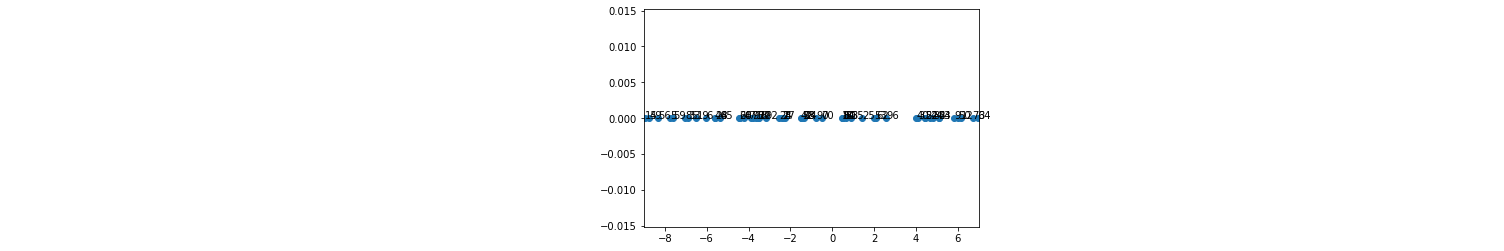

In [164]:
small_days_sentiment=[]
medium_days_sentiment = []
large_days_sentiment = []
for x in cluster_labels:
    small_days_sentiment.append(1000*parsed_sentiments[x]['3_days'])
    medium_days_sentiment.append(parsed_sentiments[x]['5_days'])
    large_days_sentiment.append(parsed_sentiments[x]['10_days'])

# fig,ax = plt.subplots(figsize = (20,4))
fig, ax = plt.subplots()
# fig(figsize = (20,20))
plt.scatter(small_days_sentiment,np.zeros(len(cluster_labels)))
label_graph=[str(list(cluster_labels)[i]) for i in range(len(cluster_labels))]
plt.xlim(-9,7)
for i,txt in enumerate(label_graph):
    ax.annotate(txt,(small_days_sentiment[i],np.zeros(len(cluster_labels))[i]))


# FORECASTING
We now, test our model on the tested data (the 20% headlines left)


## Definition of functions

In [165]:
def clean(headlines, stopwords):
    '''
    Args:
    headlines: pd.Series
    '''
    headlines = headlines.str.lower()
    
    headlines.replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\$&]','', inplace = True, regex=True)
    extensions_list = ['co','reuters','Reuters','bloomberg', 'may','also','could','would', 'na','&amp','gets', 'getting', 'get','must','might','may','across','among','beside','however','yet','within']+list(ascii_lowercase)

    stopwords = stopwords.union(set(extensions_list))

    wordlist = filter(None, " ".join(list(set(list(itertools.chain(*headlines.str.split(' ')))))).split(" "))

    headlines = [' '.join(filter(None,filter(lambda word: word not in stopwords, line))) for line in headlines.str.lower().str.split(' ')]
    
    return headlines

In [185]:
def closest_cluster_sentiment(headline, tickers):
    '''
    Returns the closest cluster to the new headline
    
    Args:
    headline (str)
    clusters (dict)
    '''
    
    n_neighors = 5
    
    # Get SVO of the new headline
    cleaned_headline = clean(pd.Series([headline]), stop)
    ticker_info = parse_header1(cleaned_headline[0], tickers, None)
    
    headline_sentiment = {}
    
    headline_sentiment = {
        '3_days': [],
        '5_days': [],
        '10_days': []
    }
    
    if len(ticker_info) != 0:
        try :
            for ls in ticker_info:
                ticker_key = ls[3]

                if ticker_key == 'obj':
                    ticker = ls[2]
                    svo = [ls[0],ls[1]]
                    svo_vec = [np.concatenate((model.wv[ls[1].upper()], model.wv[ls[0].upper()]))]

    #                 close_neighbors = clf.kneighbors(svo_vec,n_neighbors)
    #                 cluster_list = [labels[neigh[1][0][i]] for i in range(n_neighbors)]

                if ticker_key == 'sub':
                    ticker = ls[0]
                    svo = [ls[1],ls[2]]
                    svo_vec = [np.concatenate((model.wv[ls[1].upper()], model.wv[ls[2].upper()]))]


                close_neighbors = clf.kneighbors(svo_vec,n_neighbors)
                clusters_list = [labels[close_neighbors[1][0][i]] for i in range(n_neighors)]
                distances_list = [close_neighbors[0][0][i] for i in range(n_neighors)]

                closest_cluster_label = clusters_list[0]
                for horizon in horizons:
                    closest_cluster_horizon_sentiment = parsed_sentiments[closest_cluster_label]['{}_days'.format(horizon)]
                    headline_sentiment['{}_days'.format(horizon)] = closest_cluster_horizon_sentiment
                
        except:
            return None


            
#             for horizon in horizons:
#                 for cluster in clusters_list:
#                     headline_sentiment['{}_days'.format(horizon)].append(parsed_sentiments[cluster]['{}_days'.format(horizon)])
                
#                 headline_sentiment['{}_days'.format(horizon)] = np.mean(headline_sentiment['{}_days'.format(horizon)]) 
             

                
    return headline_sentiment



In [167]:
def inverse_distance_sentiment(headline, parsed_sentiments, tickers, labels, horizons):
    '''
    Returns the closest cluster to the new headline
    
    Args:
    headline (str)
    clusters (dict)
    tickers (dict): list of company name: ticker pairs
    horizons (iterable): iterable of horizon lengths to consider
    '''
    p = 2
    n_neighbours = len(labels)
    
    # Get SVO of the new headline
    cleaned_headline = clean(pd.Series([headline]), stop)
    ticker_info = parse_header1(cleaned_headline[0], tickers, None)
    
    headline_sentiment = {'{}_days'.format(horizon): [] for horizon in horizons}
    
    if len(ticker_info) == 0:
        return None
    try :
        for ls in ticker_info:
            ticker_key = ls[3]

            if ticker_key == 'obj':
                ticker = ls[2]
                svo = [ls[0],ls[1]]
                svo_vec = [np.concatenate((model.wv[ls[1].upper()], model.wv[ls[0].upper()]))]

            elif ticker_key == 'sub':
                ticker = ls[0]
                svo = [ls[1],ls[2]]
                svo_vec = [np.concatenate((model.wv[ls[1].upper()], model.wv[ls[2].upper()]))]

            else:
                # Skip if this is a subobj ticker label
                continue

            neighbours = clf.kneighbors(svo_vec, n_neighbours)
            clusters_list = list(set([labels[neighbours[1][0][i]] for i in range(n_neighbours)]) & set(list(parsed_sentiments.keys())))
            distances_list = [neighbours[0][0][i] for i in range(n_neighbours)]

            new_clusters_list = []
            new_distances_list = []

            for index, label in enumerate(clusters_list):
                if label in parsed_sentiments:
                    new_clusters_list.append(clusters_list[index])
                    new_distances_list.append(distances_list[index])


            distances_list = new_distances_list
            clusters_list = new_clusters_list
            
            #### NOTE! This is not correct

            for horizon in horizons:
                if 0 in distances_list :
                    headline_sentiment['{}_days'.format(horizon)] = parsed_sentiments[clusters_list[0]]['{}_days'.format(horizon)]
                else:
                    weights = np.array(list(map(lambda x: x**(-p), np.array(distances_list))))
                    sentiments = [parsed_sentiments[i]['{}_days'.format(horizon)] for i in clusters_list]
                    
                    if len(sentiments) == 0:
                        print(headline)
                    
                    if len(weights) == 0:
                        print(headline)
                        
                    print('sentiments', sentiments)
                    print('')
                    print('weights', weights)
                        
                    headline_sentiment['{}_days'.format(horizon)] = np.average(sentiments, weights = weights)
                    
                    print(headline_sentiment['{}_days'.format(horizon)])
                    
                    if np.isnan(headline_sentiment['{}_days'.format(horizon)]):
                        print('was nan before')
                        headline_sentiment['{}_days'.format(horizon)] = None


    except:
        print('exception')
        return None
    
    all_empty = True
    for val in headline_sentiment.values():
        if type(val) == np.float64:
            all_empty = False
            break
            
    if all_empty:
        print('all empty')
        return None

    return headline_sentiment


In [183]:
####################################################################################################################
# This is a draft cell right ? we can delete it I think 
####################################################################################################################

nlp = spacy.load('en_core_web_sm')
fake_news = 'Conor cuts investment'

# def parse_header(header, max_company_name_length = max((len(x) for x in tickers))):
# def parse_header1(header,tickers,orig):
# parsed_words.append([sub, verb, obj, tick, header, orig])

# print(closest_cluster(fake_news, parsed_sentiments, tickers))
# svo_vec = [np.concatenate((model.wv['CUTS'], model.wv['BANK']))]
# tested_news = "Food for thought: investing in the future of food"

# dictionary = closest_cluster_sentiment(fake_news, parsed_sentiments, tickers)
# output = inverse_distance_sentiment(fake_news, parsed_sentiments, tickers, labels, horizons)

output = closest_cluster_sentiment(fake_news, tickers)

print(output)

# print(parsed_sentiments[40])

# print(list(parsed_sentiments.keys))

# print(type(model.wv['CUTS']))
# neigh = clf.kneighbors(svo_vec,n_neighbors)
# print(neigh[1]0])
# print([labels[neigh[1][0][i]] for i in range(5)])
# print(labels)

[['conor', 'cuts', '__AIV', 'obj', 'conor cuts investment', None]]
[40, 40, 40, 40, 40]
[15.888278272711924, 16.431919226872143, 16.445430666054428, 16.644132065574958, 18.01880626591433]
{'3_days': 0.0040145523348318135, '5_days': 0.0033655630409184533, '10_days': 1.8041324348852934e-05}


## Computation of the sentiment for each headline based on our model 

In [186]:
testing_output = []

for index in test_data.index:
    date = test_data.loc[index, 'Date']
    headline = test_data.loc[index, 'Headlines']
    
    if test_data.loc[index, 'Tick_Type'] == 'obj':
        ticker = test_data.loc[index, 'Obj']
    if test_data.loc[index, 'Tick_Type'] == 'sub':
        ticker = test_data.loc[index, 'Sub']
#     else:
#         ticker = None
    info = {
        'date': date,
        'headline': headline,
        'ticker' : ticker
    }
    
#     horizon_sentiments = inverse_distance_sentiment(
#         headline = headline,
#         parsed_sentiments = parsed_sentiments,
#         tickers = tickers,
#         labels = labels,
#         horizons = horizons
#     )

    horizon_sentiments = closest_cluster_sentiment(
        headline = headline,
        tickers = tickers
    )
    
    if horizon_sentiments is not None:
        for horizon in horizons:
            info['{}_days'.format(horizon)] = horizon_sentiments['{}_days'.format(horizon)]
            
        testing_output.append(info)

In [187]:
testing_df = pd.DataFrame(testing_output)
testing_df

date                                           headline  ticker  \
0   2019-02-03  spacex launch crew dragon lifts us seeks run m...    __CF   
1   2019-02-04  instinctif partners advert one agree strategic...   __AZO   
2   2019-02-04  eu warns liquidity risks financial disruption ...  __ALXN   
3   2019-02-04  diageo gives uk staff fully paid week equal pa...   __DRE   
4   2019-02-04               herald tried tested investment trust   __FRT   
..         ...                                                ...     ...   
320 2019-12-06  facebook create jobs new london engineering ce...    __FB   
321 2019-12-06  nodeal brexit see uk flooded cheap copies brit...   __DRE   
322 2019-12-07  swiss stocks keep lid european shares pharma d...  __HBAN   
323 2019-12-07                     ancient art sparks controversy   __AAP   
324 2019-12-10                 breaking bad movie hit netflix amc  __NFLX   

       3_days    5_days   10_days  
0   -0.002281 -0.000208 -0.002106  
1    0.005835  0.003633  0.001299  
2    0.005835  0.003633  0.001299  
3   -0.008965 -0.008933  0.003981  
4    0.002098  0.001334  0.000438  
..        ...       ...       ...  
320  0.005835  0.003633  0.001299  
321  0.001988  0.002877  0.003652  
322 -0.007592 -0.000883  0.003892  
323  0.002098  0.001334  0.000438  
324 -0.003899 -0.001510 -0.003428  

[325 rows x 6 columns]

# Test our model

In [189]:
#Compute the real average of cumulative returns for our tested data
for horizon in horizons:
    for i in testing_df.index:
        date = testing_df.loc[i,'date']
        ticker = testing_df.loc[i,'ticker']
        ticker = ticker.replace('__','')
        cumul = lookup_cumul_returns(ticker, date, horizon)
        testing_df.loc[i,str(horizon)+'_days_actual'] = cumul
        
testing_df = testing_df.dropna()
testing_df

date                                           headline  ticker  \
0   2019-02-03  spacex launch crew dragon lifts us seeks run m...    __CF   
1   2019-02-04  instinctif partners advert one agree strategic...   __AZO   
2   2019-02-04  eu warns liquidity risks financial disruption ...  __ALXN   
3   2019-02-04  diageo gives uk staff fully paid week equal pa...   __DRE   
4   2019-02-04               herald tried tested investment trust   __FRT   
..         ...                                                ...     ...   
149 2019-06-27          neil woodfords debacle teach us liquidity    __CF   
150 2019-06-27  indians money swiss banks falls hits secondlow...   __STI   
151 2019-06-27  singapore airlines malaysia airlines explore w...   __AAL   
152 2019-06-28        old car youre alone vehicle age hits record   __CAH   
153 2019-06-28   startup letting people fly drones remotely world  __PBCT   

       3_days    5_days   10_days  3_days_actual  5_days_actual  \
0   -0.002281 -0.000208 -0.002106       0.009418       0.011963   
1    0.005835  0.003633  0.001299      -0.016197      -0.015573   
2    0.005835  0.003633  0.001299      -0.011615       0.013524   
3   -0.008965 -0.008933  0.003981      -0.001269      -0.012869   
4    0.002098  0.001334  0.000438      -0.010727      -0.012385   
..        ...       ...       ...            ...            ...   
149  0.002098  0.001334  0.000438      -0.007411      -0.012501   
150  0.006701  0.002762  0.003164      -0.024484      -0.023681   
151  0.002098  0.001334  0.000438      -0.004497      -0.019834   
152  0.002098  0.001334  0.000438      -0.014239      -0.012482   
153  0.002098  0.001334  0.000438      -0.011851      -0.007505   

     10_days_actual  
0          0.008339  
1         -0.010508  
2          0.004874  
3         -0.028214  
4         -0.018823  
..              ...  
149       -0.003993  
150       -0.000958  
151       -0.004841  
152       -0.004570  
153       -0.001128  

[131 rows x 9 columns]

### Testing the direction

We want to know how many times our prediction has the same sign that the reality, so we compute the product of those two and we count the number of positive results

In [190]:
#Multiplication of the reality and the prediction
for horizon in horizons:
    testing_df[str(horizon)+'_dir_comparison'] = testing_df[str(horizon)+'_days_actual']*testing_df[str(horizon)+'_days']
  
testing_df 

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


date                                           headline  ticker  \
0   2019-02-03  spacex launch crew dragon lifts us seeks run m...    __CF   
1   2019-02-04  instinctif partners advert one agree strategic...   __AZO   
2   2019-02-04  eu warns liquidity risks financial disruption ...  __ALXN   
3   2019-02-04  diageo gives uk staff fully paid week equal pa...   __DRE   
4   2019-02-04               herald tried tested investment trust   __FRT   
..         ...                                                ...     ...   
149 2019-06-27          neil woodfords debacle teach us liquidity    __CF   
150 2019-06-27  indians money swiss banks falls hits secondlow...   __STI   
151 2019-06-27  singapore airlines malaysia airlines explore w...   __AAL   
152 2019-06-28        old car youre alone vehicle age hits record   __CAH   
153 2019-06-28   startup letting people fly drones remotely world  __PBCT   

       3_days    5_days   10_days  3_days_actual  5_days_actual  \
0   -0.002281 -0.000208 -0.002106       0.009418       0.011963   
1    0.005835  0.003633  0.001299      -0.016197      -0.015573   
2    0.005835  0.003633  0.001299      -0.011615       0.013524   
3   -0.008965 -0.008933  0.003981      -0.001269      -0.012869   
4    0.002098  0.001334  0.000438      -0.010727      -0.012385   
..        ...       ...       ...            ...            ...   
149  0.002098  0.001334  0.000438      -0.007411      -0.012501   
150  0.006701  0.002762  0.003164      -0.024484      -0.023681   
151  0.002098  0.001334  0.000438      -0.004497      -0.019834   
152  0.002098  0.001334  0.000438      -0.014239      -0.012482   
153  0.002098  0.001334  0.000438      -0.011851      -0.007505   

     10_days_actual  3_dir_comparaison  5_dir_comparaison  10_dir_comparaison  
0          0.008339          -0.000021          -0.000002       -1.755954e-05  
1         -0.010508          -0.000095          -0.000057       -1.364516e-05  
2          0.004874          -0.000068           0.000049        6.328816e-06  
3         -0.028214           0.000011           0.000115       -1.123111e-04  
4         -0.018823          -0.000023          -0.000017       -8.235709e-06  
..              ...                ...                ...                 ...  
149       -0.003993          -0.000016          -0.000017       -1.747061e-06  
150       -0.000958          -0.000164          -0.000065       -3.031601e-06  
151       -0.004841          -0.000009          -0.000026       -2.118110e-06  
152       -0.004570          -0.000030          -0.000017       -1.999520e-06  
153       -0.001128          -0.000025          -0.000010       -4.934823e-07  

[131 rows x 12 columns]

In [191]:
#Count of the positive result
direction_test = testing_df
direction_result_dict ={}
for horizon in horizons :
    pos = len(direction_test.loc[direction_test[str(horizon)+'_dir_comparison']>0,:])
    tot = len(direction_test)
    direction_result_dict[horizon]=pos/tot

#Ratio of positive results
direction_result_dict  

{3: 0.46564885496183206, 5: 0.5267175572519084, 10: 0.44274809160305345}

### Testing the magnitude

We want to know is our prediction gives a relevent magnitude, so we compute the relative gap of average cumulative returns between the prediction and the reality 

In [ ]:
magnitude_test = testing_df

for horizon in horizons :
    magnitude_test[str(horizon)+'_rel_gap']= abs(magnitude_test[str(horizon)+'_days_actual']-magnitude_test[str(horizon)+'_days'])/magnitude_test[str(horizon)+'_days_actual']
    
magnitude_test